In [76]:
# set gpu allocation size 

In [29]:
import os
import tensorflow as tf
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import datetime
import matplotlib.pyplot as plt

Fd='/glade/derecho/scratch/yizhu/comp576/ORIENT'
os.chdir(Fd)
os.listdir()
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device='cpu'
print(device)
# GPU info
!nvidia-smi

cpu
NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



# model

In [31]:
with tf.device(device):
    input_dim = 964
    nnode1=412
    nnode2=105
    nnode3=116
    nnode4=128
    nnode5=1
    drop_rate1=0.36
    drop_rate2=0.09
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(nnode1, input_dim=input_dim, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(drop_rate1),
        tf.keras.layers.Dense(nnode2, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(drop_rate2),
        tf.keras.layers.Dense(nnode3, activation='relu'),
        tf.keras.layers.Dense(nnode4, activation='relu'),
        tf.keras.layers.Dense(nnode5, activation='linear')
    ])
    
    # define loss function and optimizer with tf
    lr=0.01
    loss_object = tf.keras.losses.MeanSquaredError()
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    # compiler the model
    model.compile(optimizer=optimizer, loss=loss_object, metrics=['mse'])

model.summary()

Model: "sequential_192"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_950 (Dense)           (None, 412)               397580    
                                                                 
 batch_normalization_385 (B  (None, 412)               1648      
 atchNormalization)                                              
                                                                 
 dropout_384 (Dropout)       (None, 412)               0         
                                                                 
 dense_951 (Dense)           (None, 105)               43365     
                                                                 
 batch_normalization_386 (B  (None, 105)               420       
 atchNormalization)                                              
                                                                 
 dropout_385 (Dropout)       (None, 105)            

In [47]:
# get drop rate for dropout layer
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Dropout):
        print(layer.rate)

0.3675296869826746
0.09089945070039931


# train and test model 

## make loader

In [32]:
# load
with open('ch11_data3.pkl','rb') as f:
  data=pickle.load(f)

In [33]:
# only use 1/1000 of the data
data=data[::100]

In [34]:
# input and target
input=data.iloc[:,2:-2]
target=data.iloc[:,-2]

In [35]:
# 80% train, 20% test
x_train,x_test,y_train,y_test=train_test_split(input,target,test_size=0.2,shuffle=True)

In [36]:
# make cross validation that is 0.2 of the train data
kf = KFold(n_splits=5)

In [38]:
# print the shape of the data
print('x_train shape:',x_train.shape)
print('x_test shape:',x_test.shape)
print('y_train shape:',y_train.shape)
print('y_test shape:',y_test.shape)

x_train shape: (7884, 964)
x_test shape: (1972, 964)
y_train shape: (7884,)
y_test shape: (1972,)


## train and test

In [45]:
# fit the model
fold=0
batch_size=x_train.shape[0]//10
# buffer_size=1000 if x_train.shape[0]>10000 else 10000
nepo=10
all_history = []  # list to store history for each fold
for train_idx, val_idx in kf.split(x_train):
    fold+=1
    print('fold: ',fold)
    train_ds=tf.data.Dataset.from_tensor_slices((x_train.iloc[train_idx,:],y_train.iloc[train_idx]))
    val_ds=tf.data.Dataset.from_tensor_slices((x_train.iloc[val_idx,:],y_train.iloc[val_idx]))
    train_ds=train_ds.batch(batch_size)
    val_ds=val_ds.batch(batch_size)
    history=model.fit(train_ds,epochs=nepo,validation_data=val_ds)
    all_history.append(history.history)  # append history for current fold

# calculate average history
avg_history = {}
for key in all_history[0].keys():
    avg_history[key] = np.mean([fold_history[key] for fold_history in all_history], axis=0)


fold:  1
Epoch 1/10
9/9 [==============================] - 0s 19ms/step - loss: 0.2084 - mse: 0.2084 - val_loss: 0.2353 - val_mse: 0.2353
Epoch 2/10
9/9 [==============================] - 0s 16ms/step - loss: 0.1915 - mse: 0.1915 - val_loss: 0.1834 - val_mse: 0.1834
Epoch 3/10
9/9 [==============================] - 0s 15ms/step - loss: 0.1891 - mse: 0.1891 - val_loss: 0.1670 - val_mse: 0.1670
Epoch 4/10
9/9 [==============================] - 0s 16ms/step - loss: 0.1634 - mse: 0.1634 - val_loss: 0.1677 - val_mse: 0.1677
Epoch 5/10
9/9 [==============================] - 0s 18ms/step - loss: 0.1714 - mse: 0.1714 - val_loss: 0.1876 - val_mse: 0.1876
Epoch 6/10
9/9 [==============================] - 0s 18ms/step - loss: 0.1717 - mse: 0.1717 - val_loss: 0.1324 - val_mse: 0.1324
Epoch 7/10
9/9 [==============================] - 0s 17ms/step - loss: 0.1477 - mse: 0.1477 - val_loss: 0.1472 - val_mse: 0.1472
Epoch 8/10
9/9 [==============================] - 0s 19ms/step - loss: 0.1373 - mse: 0.1

Text(0.5, 0, 'epoch')

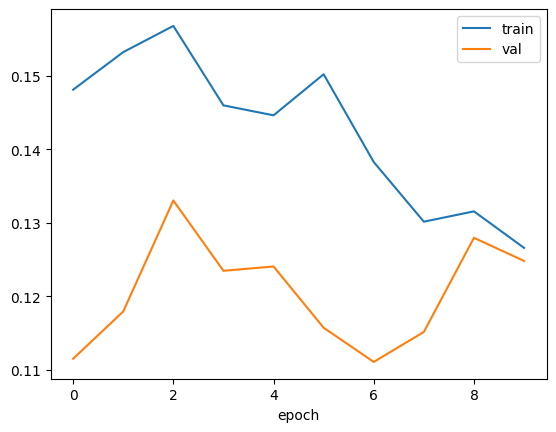

In [46]:
# plot history
plt.plot(avg_history['loss'],label='train')
plt.plot(avg_history['val_loss'],label='val')
plt.legend()
plt.xlabel('epoch')

62/62 [==============================] - 0s 1ms/step


0.594963654538247


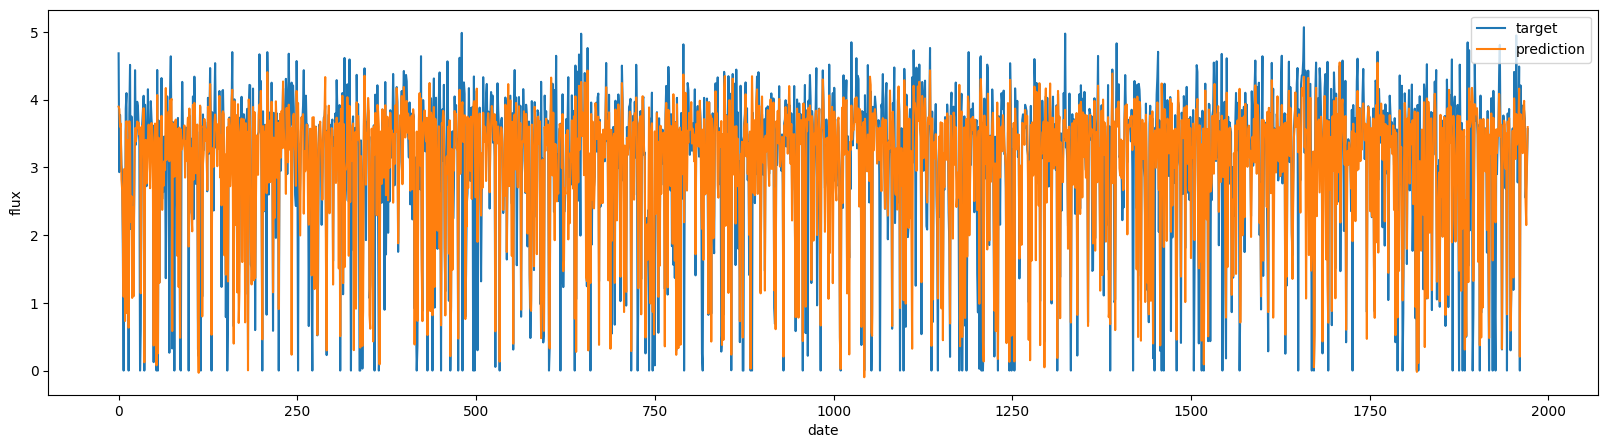

In [121]:
# predict and plot
y_pred=model.predict(x_test)
plt.figure(figsize=(20,5))
plt.plot(range(len(y_test)),y_test,label='target')
plt.plot(range(len(y_test)),y_pred,label='prediction')
plt.legend()
plt.xlabel('date')
plt.ylabel('flux')
# print r2 score
from sklearn.metrics import r2_score
print(r2_score(y_test,y_pred))

# test the model on storm event

In [66]:
# predict on data between datetime(2017,3,25) datetime(2017,3,1,0)
stormdata=pickle.load(open('ch11_data2.pkl','rb'))

# make ds
x_storm=stormdata.iloc[:,2:-2]
y_storm=stormdata.iloc[:,-2]
batch_size=32

with tf.device(device):
    # make data loader
    storm_ds=tf.data.Dataset.from_tensor_slices((x_storm.values,y_storm.values))
    # shuffle and batch
    storm_ds=storm_ds.shuffle(10000).batch(batch_size)